# LwM Maps Hack Day 1, 1 August 2019
## Identify built environment via OS map images

* Ruth Ahnert
* David Beavan
* Joel Dearden
* Gethin Rees
* Am I forgetting anyone?

In [1]:
import os
from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# OS images are BIG (600MB) this stops manipulations being identifies as denial of service
Image.MAX_IMAGE_PIXELS = None

In [2]:
def resample_grayscale_from_path(path, crop=False, maxsize=1000, bandwthresh=128, blur=2, extension='_conv_', out_folder=''):
    '''given path to an image, resample, blur, return and save the image.
    Args:
        path (str): /path/to/input/file
        maxsize (int): maximum size of x or y dimension of resampled image
        bandwthresh (int): 0-255 value of brightness where >= is white and < is black
        blur (int): value of gaussiablur
        extension (str): extension appended to the processes image
        out_folder (str ): /path/to/output/file

    '''
    
    # open image
    image = Image.open(path)
    print(path)
    print('Size before rescaling =', image.size)
    
    if crop:
        width, height = image.size   # Get dimensions
        left = 2 * width/8
        top = 2 * height/8
        right = 6 * width/8
        bottom = 6 * height/8
        image = image.crop((left, top, right, bottom))

    # convert to grayscale
    gray = image.convert('L')
    
    # convert to black and white
#    bw = np.asarray(gray).copy()
#    bw[bw < bandwthresh] = 0    # Black
#    bw[bw >= bandwthresh] = 255 # White  
#    bw = Image.fromarray(bw)
    
    bw = ImageOps.autocontrast(gray, cutoff=0.5)
    
    # resample size
    bw.thumbnail([maxsize, maxsize], resample = Image.LANCZOS)
    
    # blur if needed
    if blur > 0:
        bw = bw.filter(ImageFilter.GaussianBlur(blur))
    
    print('Size after rescaling =', bw.size)

    # save file as losless png if needed
    if out_folder != '':
        image_name = '.'.join(path.split('/')[-1].split('.')[:-1])
        out_path = os.path.join(out_folder, image_name + extension + 'maxsize={}'.format(maxsize) + '.png')
        bw.save(out_path, format='png', compress_level=9, optimise='true')
        print('Done. Save file to {}'.format(out_path))

    # return image
    return bw

In [3]:
# resample map sheets from NLS full size PNGs (100s MBs)

#path = 'sheets/full'
path = 'sheets/conv'

sheets = {}

for r, d, f in os.walk(path):
    for file in f:
        if file.lower().endswith(('.png', '.tif', '.tiff')):
            filename = os.path.join(r, file)
            #sheets[filename] = resample_grayscale_from_path(filename, crop=True, out_folder='sheets/conv')
            sheets[filename] = Image.open(filename)

## Show the images

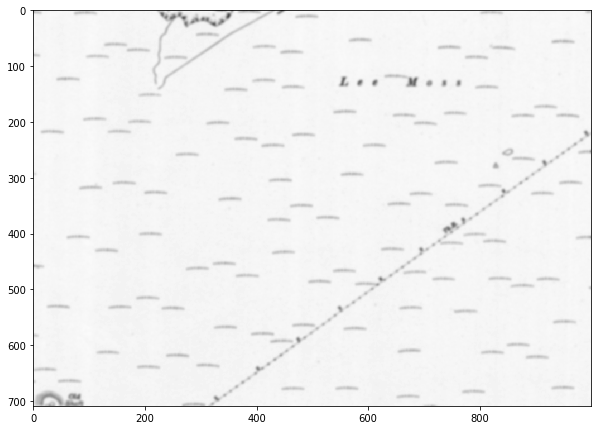

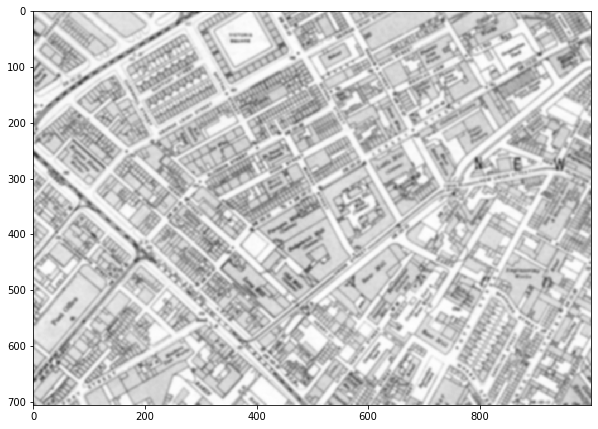

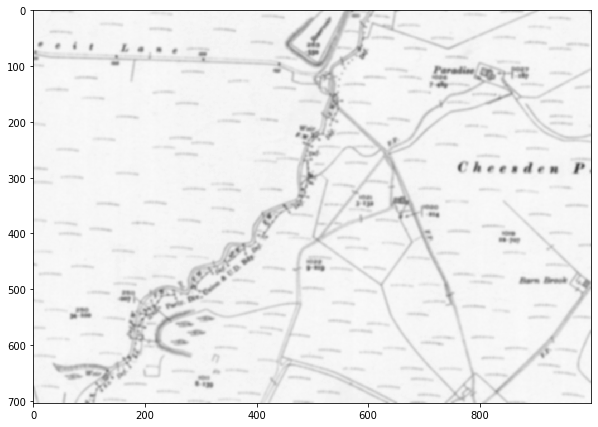

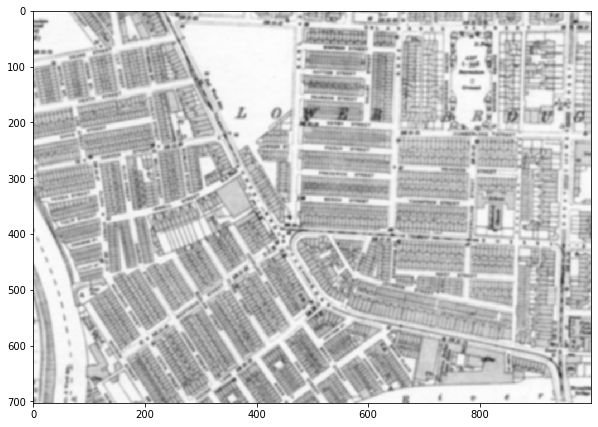

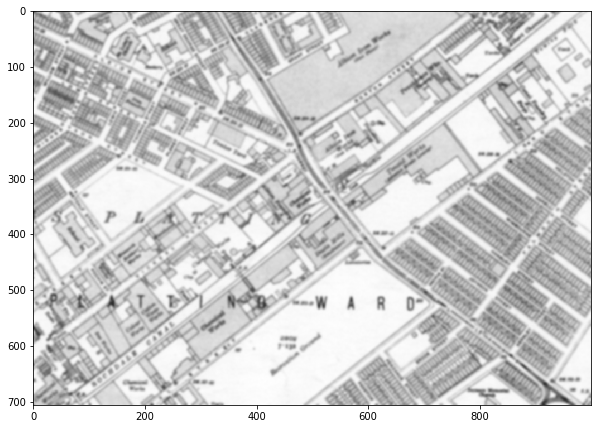

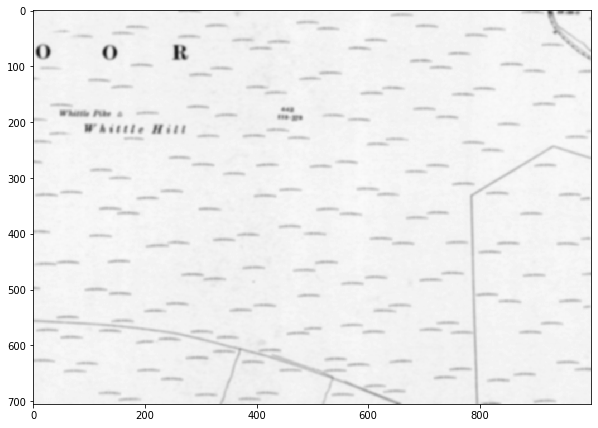

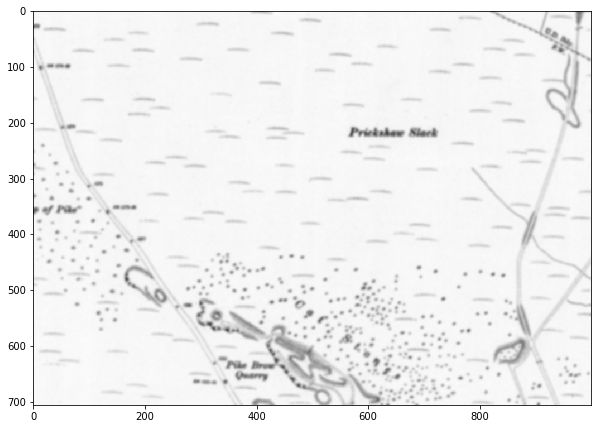

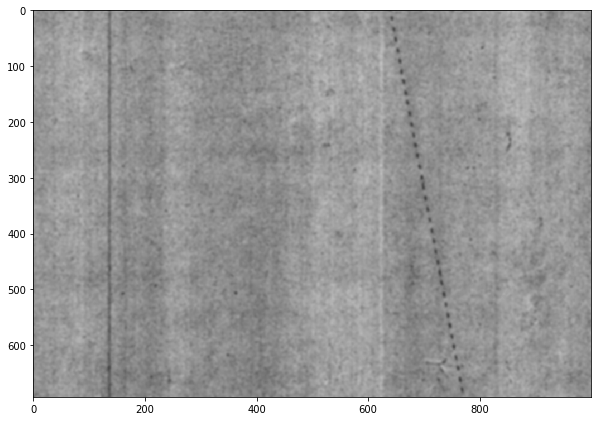

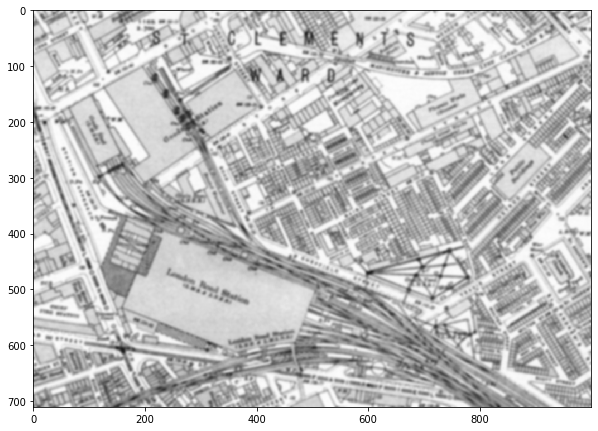

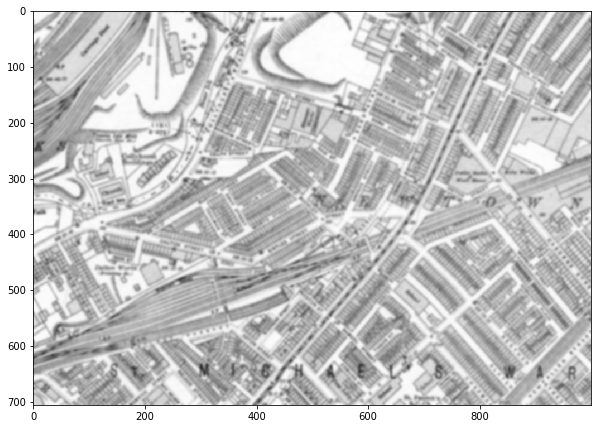

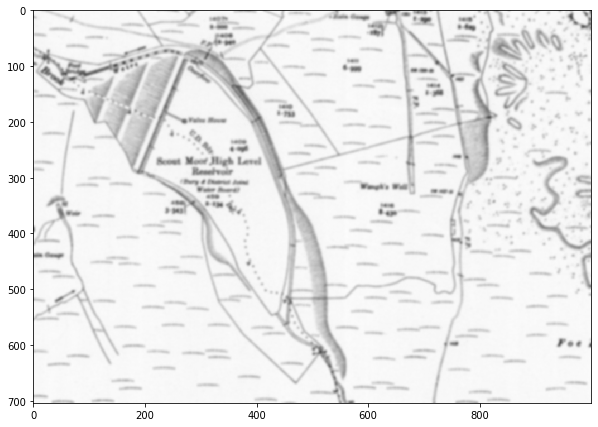

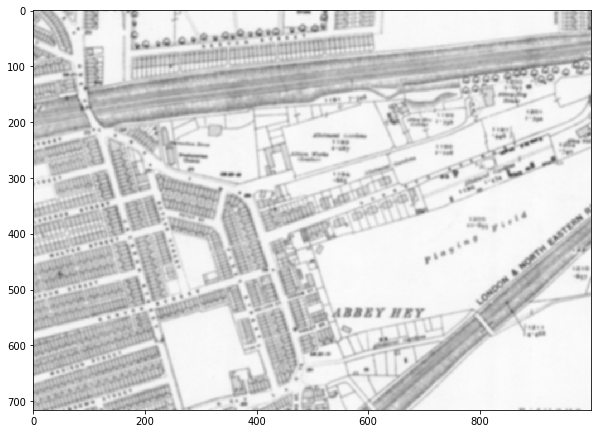

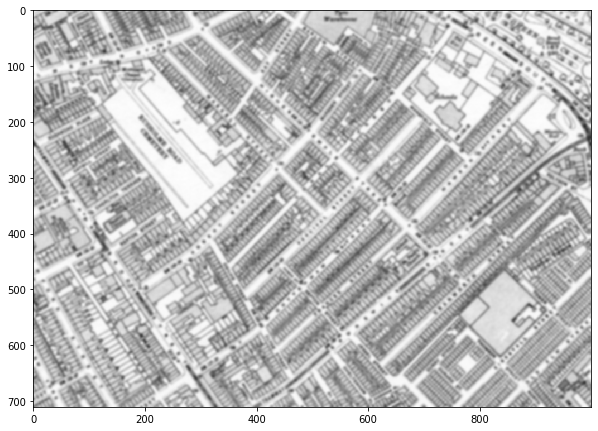

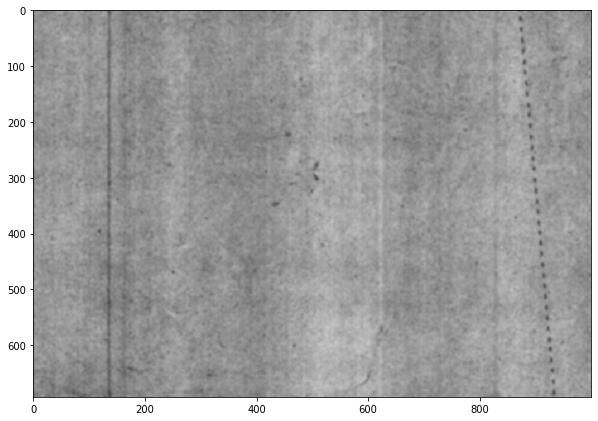

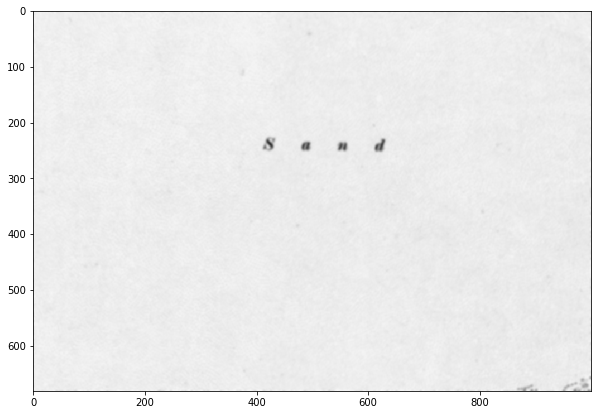

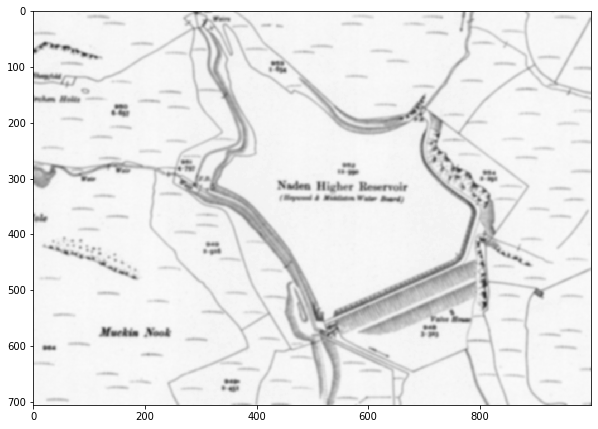

In [4]:
for sheet in sheets.values():
    plt.figure(figsize = (10,10))
    # vmin and vmax prevent imshow from automatically normalising the images for display
    plt.imshow(sheet, cmap='gray', vmin=0, vmax=255)

##### Show the histograms

Urban mass seems to show a hump in the histogram at 160-200 levels of gray

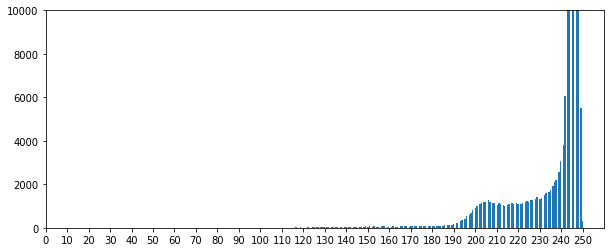

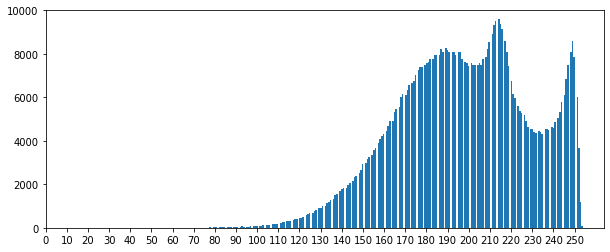

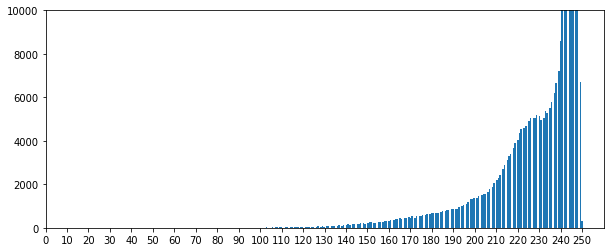

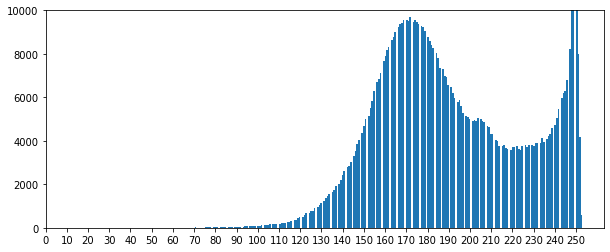

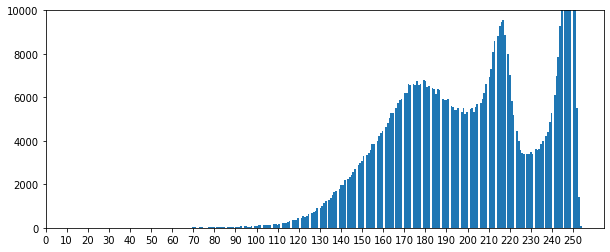

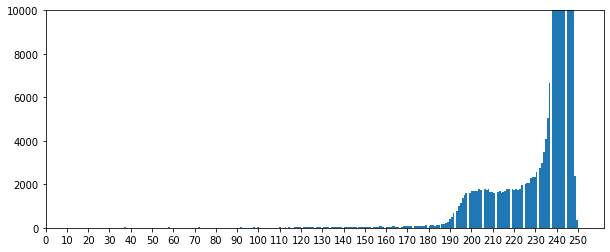

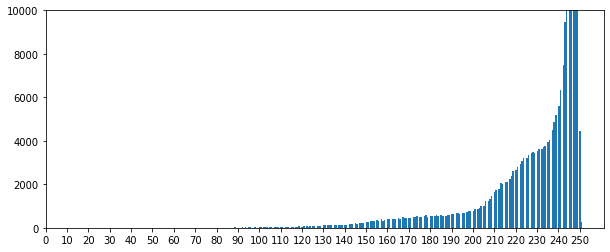

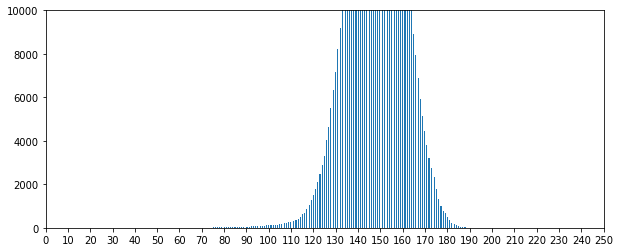

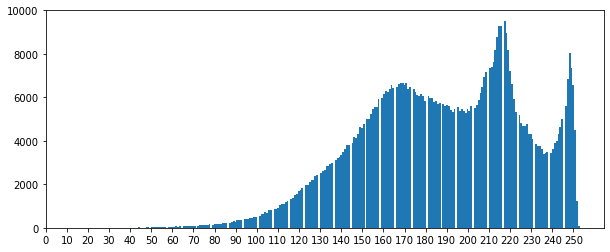

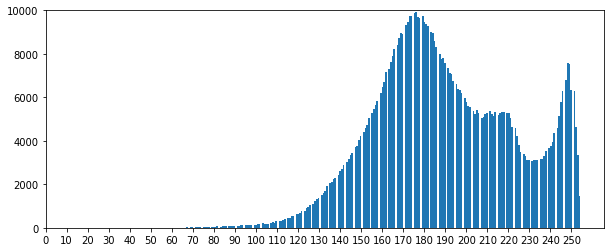

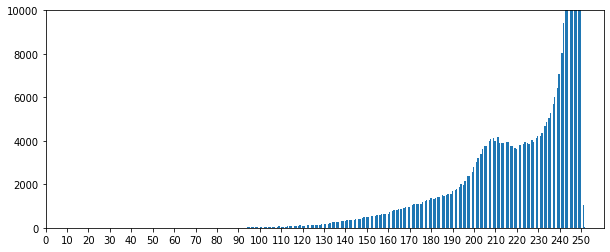

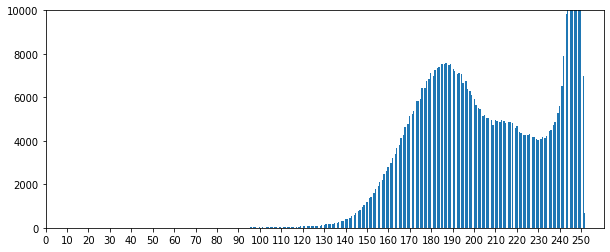

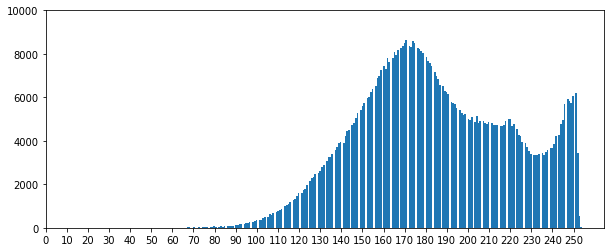

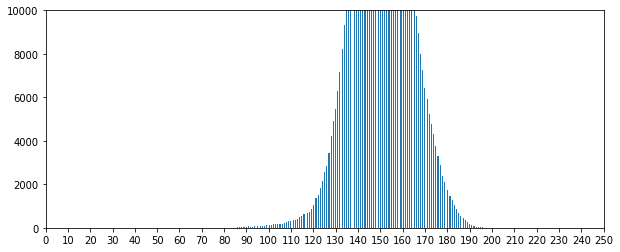

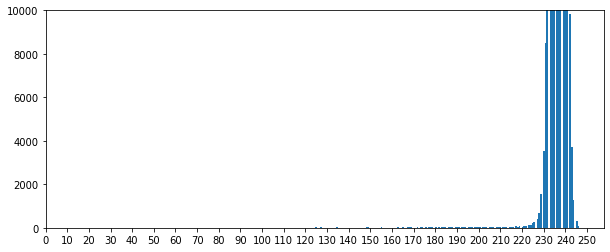

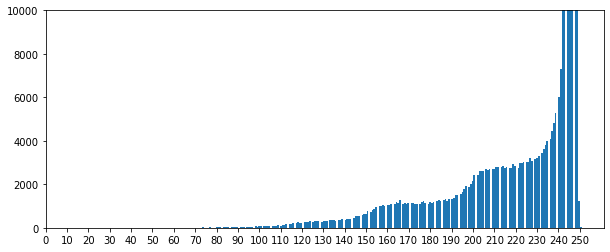

In [5]:
for sheet in sheets.values():
    plt.figure(figsize = (10,4))
    bins = plt.hist(np.array(sheet).flatten(), bins=256)
    plt.ylim(0, 10000)
    plt.xticks(range(0, 255, 10))

In [6]:
for sheet in sheets.values():
    sheetnp = np.asarray(sheet).copy()
    print(sheetnp.mean(), sheetnp.std())

243.18946967559944 10.24683540405234
197.8575566572238 31.143009578204705
237.81863636363636 17.506189712616855
191.14030725462305 34.03089117658533
202.33274362606232 34.817272419492305
239.60600992907803 12.744021273012436
240.22365155807364 17.710135454806572
148.01556132756133 12.327837209133522
187.78732630098452 37.658570400500075
190.01462889518413 33.24474869419933
233.904578125 24.028606851471633
213.7785782122905 31.604257417586442
184.4579676511955 35.820674633121435
150.17163203463204 13.10651198610073
236.31222466960352 5.320543157000051
233.33551558073654 26.14128422457118


###### Filter out that 160 to 200 range of values and show as mask

In [7]:
minthresh = 160
maxthresh = 200

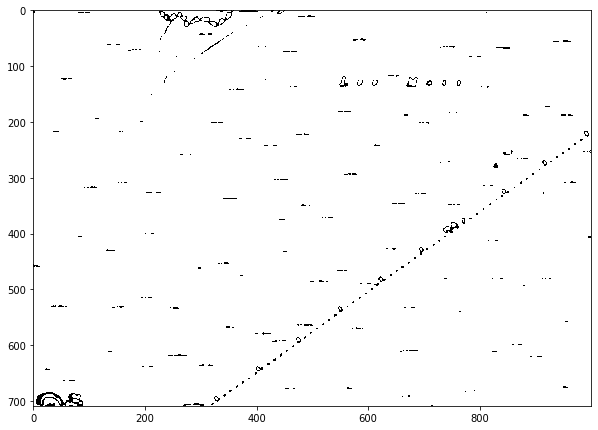

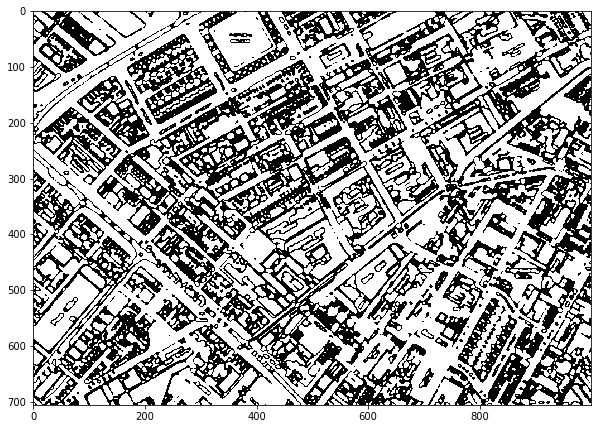

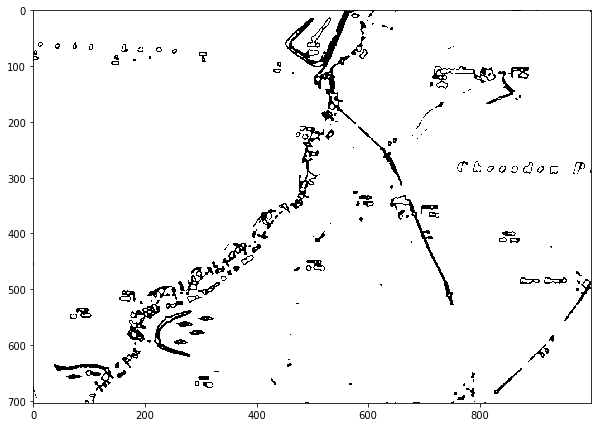

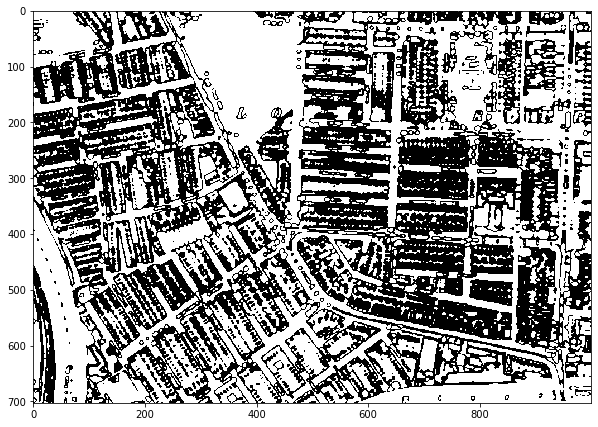

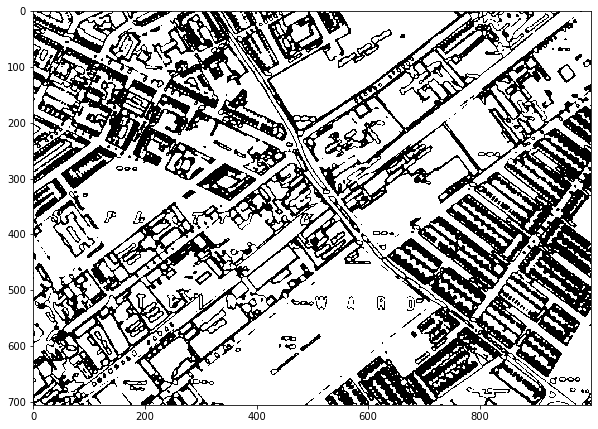

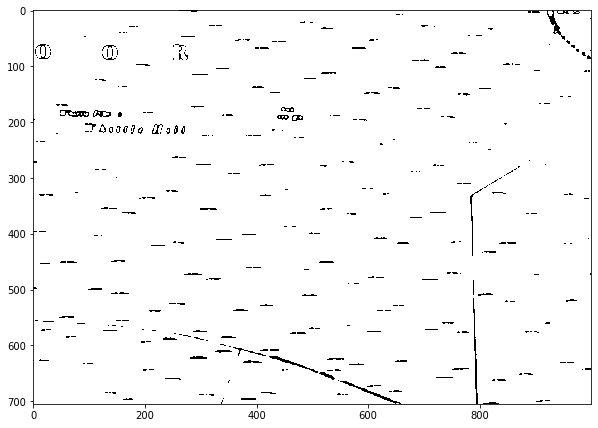

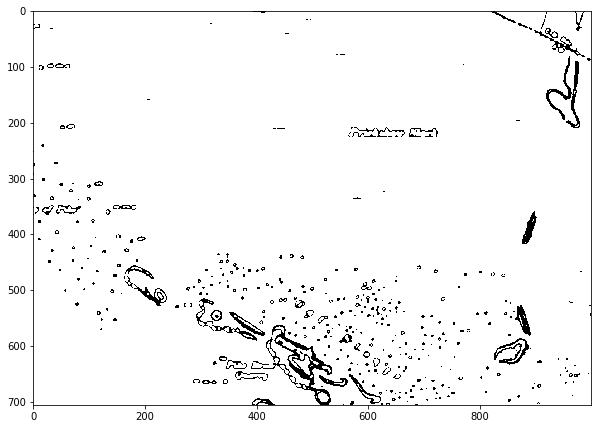

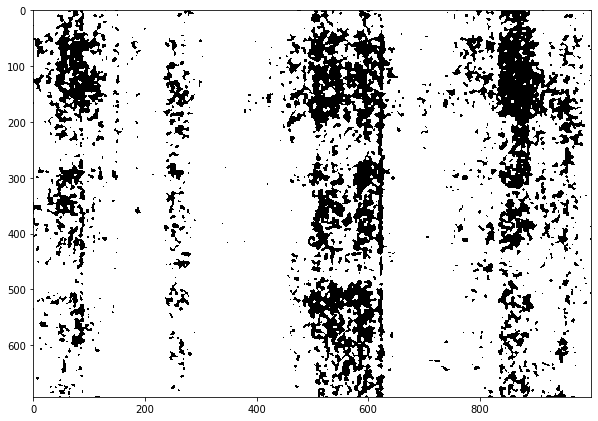

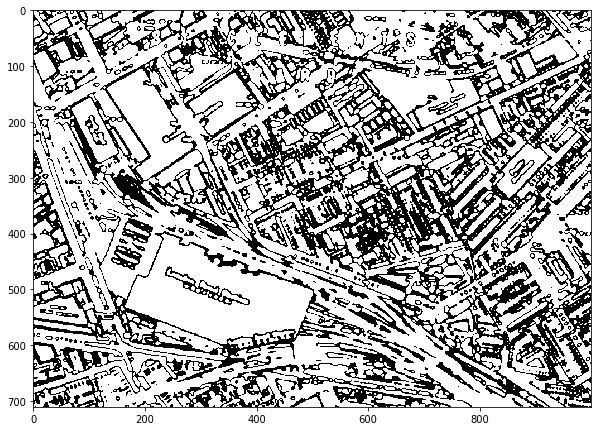

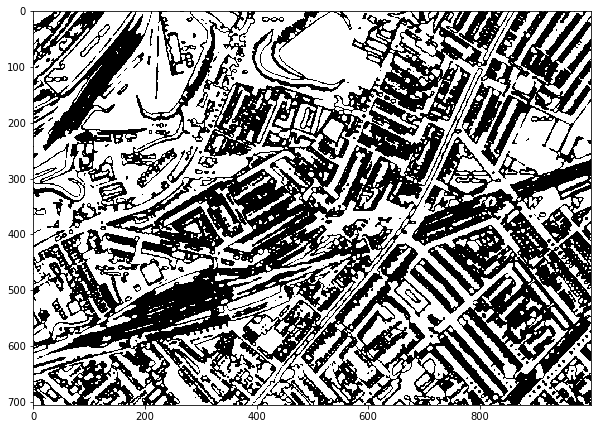

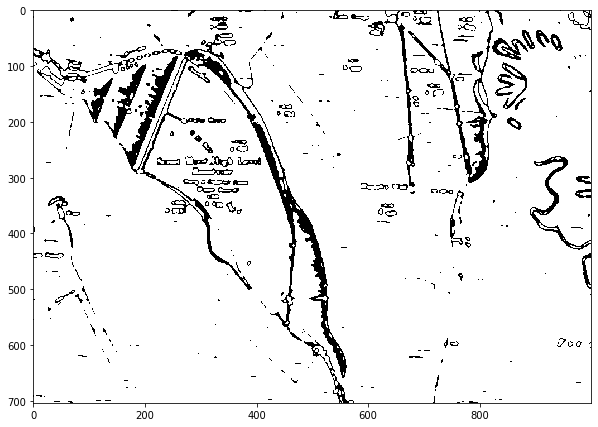

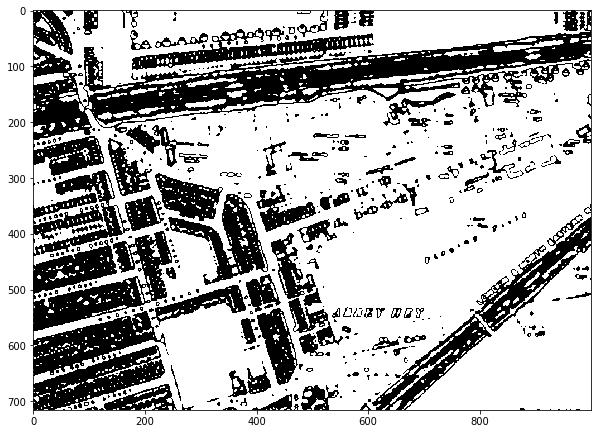

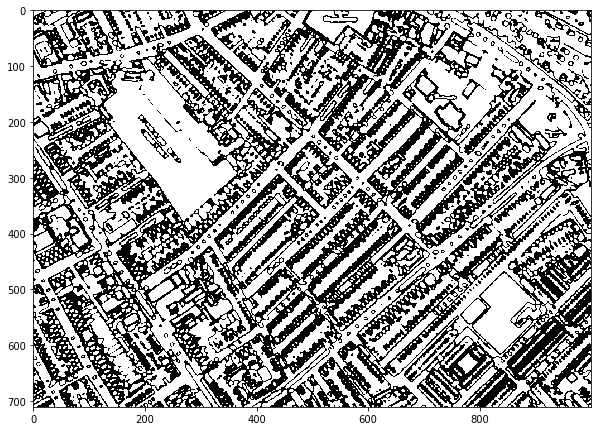

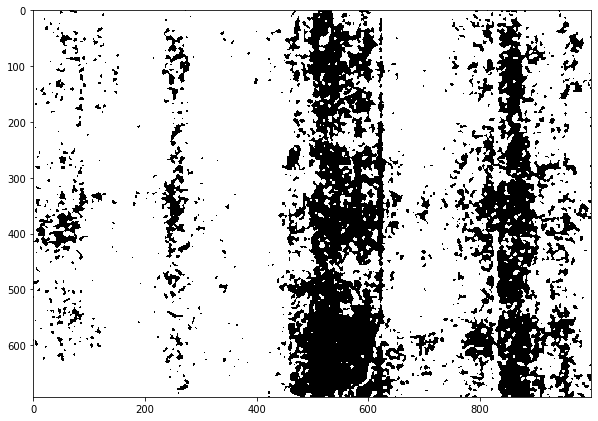

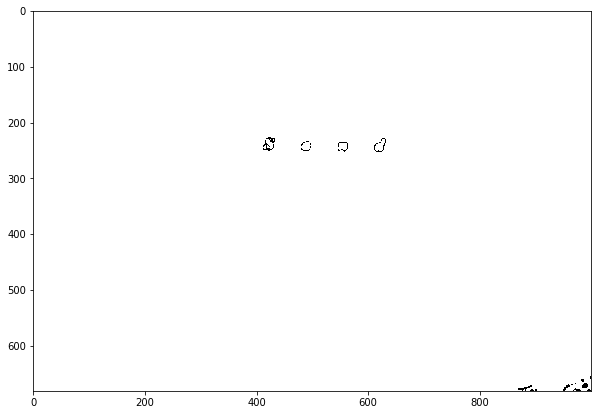

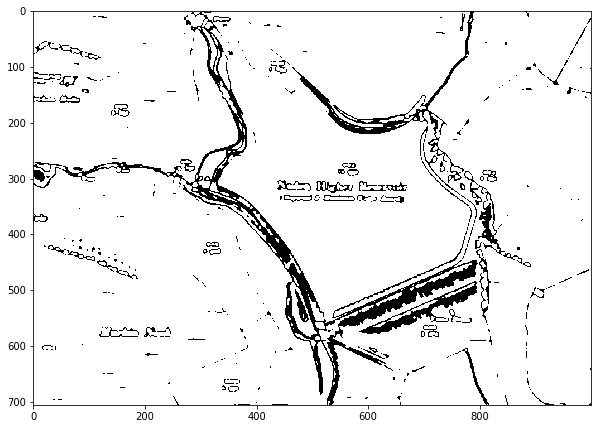

In [8]:
for sheet in sheets.values():
    plt.figure(figsize = (10,10))
    filtered = np.asarray(sheet).copy()
    mask = ((filtered >= minthresh) & (filtered < maxthresh))
    plt.imshow(np.logical_not(mask), cmap='gray')

In [9]:
results = {'sheet': [], 'mean': [], 'std': []}

for sheet in sheets:
    filtered = np.asarray(sheets[sheet]).copy()
    mask = ((filtered >= minthresh) & (filtered < maxthresh))
    
    sheetnp = np.asarray(mask).copy()
    results['sheet'].append(sheet)
    results['mean'].append(sheetnp.mean())
    results['std'].append(sheetnp.std())

df = pd.DataFrame(results)
df.set_index('sheet', inplace=True)

df.round(4)

mean     std
sheet                                                             
sheets/conv/126519530.27_01_02_conv_maxsize=100...  0.0096  0.0974
sheets/conv/126522821.27_02_01_conv_maxsize=100...  0.3956  0.4890
sheets/conv/126519590.27_01_01_conv_maxsize=100...  0.0393  0.1943
sheets/conv/126522812.27_01_01_conv_maxsize=100...  0.4537  0.4979
sheets/conv/126522821.27_01_02_conv_maxsize=100...  0.3353  0.4721
sheets/conv/126519554.27_01_01_conv_maxsize=100...  0.0193  0.1375
sheets/conv/126519599.27_01_02_conv_maxsize=100...  0.0310  0.1733
sheets/conv/126515555.27_01_01_conv_maxsize=100...  0.1745  0.3795
sheets/conv/126522845.27_01_01_conv_maxsize=100...  0.3378  0.4730
sheets/conv/126522821.27_01_01_conv_maxsize=100...  0.4638  0.4987
sheets/conv/126519521.27_02_01_conv_maxsize=100...  0.0779  0.2680
sheets/conv/126522959.27_02_01_conv_maxsize=100...  0.3340  0.4716
sheets/conv/126522845.27_02_01_conv_maxsize=100...  0.4073  0.4913
sheets/conv/126515555.27_02_01_conv_maxsize=100...  0.2334  0.4230
sheets/conv/126515555.27_01_02_conv_maxsize=100...  0.0013  0.0359
sheets/conv/126519599.27_01_01_conv_maxsize=100...  0.0731  0.2603

## TEST: Does mean work as a proxy for urban amount?

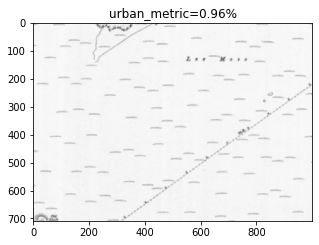

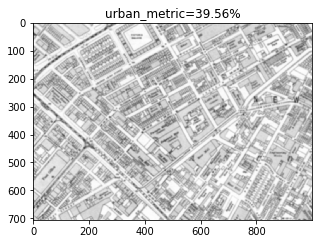

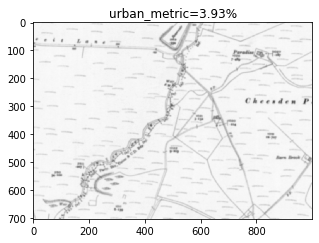

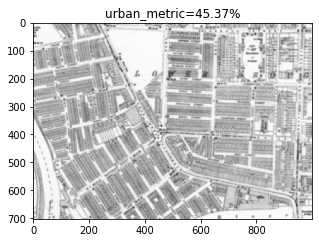

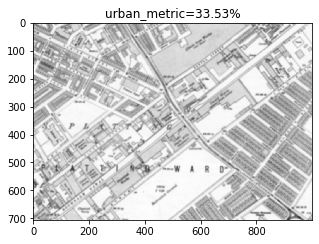

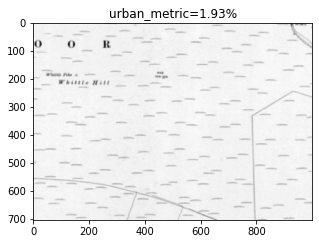

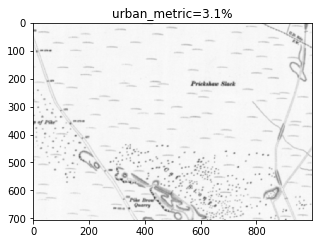

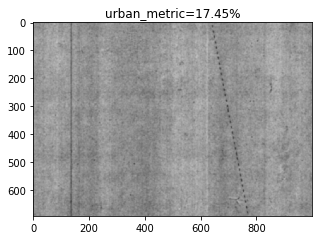

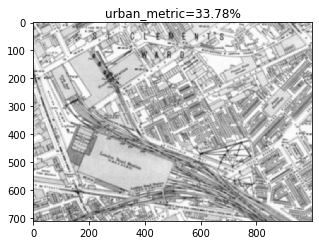

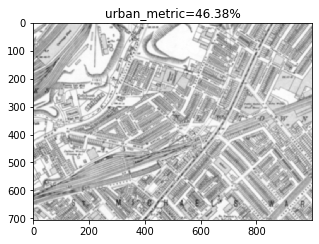

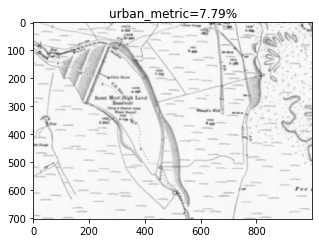

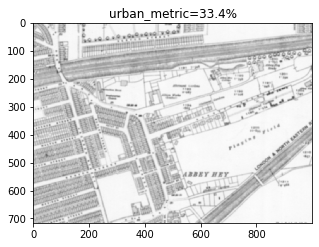

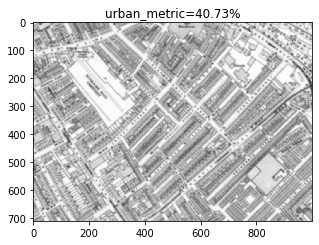

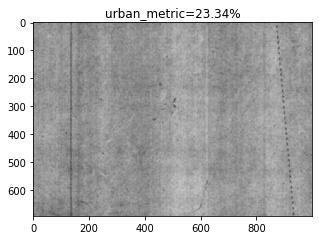

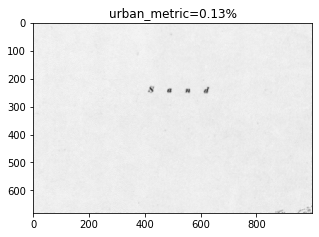

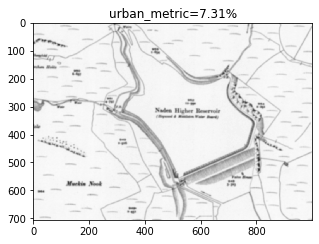

In [10]:
i = 0
for sheet in sheets.values():
    plt.figure(figsize = (5,5))
    plt.title('urban_metric=' + str((results['mean'][i] * 100).round(2)) + '%')
    i += 1
    # vmin and vmax prevent imshow from automatically normalising the images for display
    plt.imshow(sheet, cmap='gray', vmin=0, vmax=255)